# Stop the S@#$ - Toxic Comments EDA
https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

## Introduction
인터넷의 익명성이 때때로 사람들이 현실에서 하지 않을 험악한 말을 하게 만들 수 있습니다.

이를 걸러보도록 합시다.

## Objective
독성 코멘트 분류를 위한 EDA / 피쳐 엔지니어링 스타터 노트북

## Data Overview
데이터셋은 평가자에 의해 독성이 평가된 위키 말뭉치 데이터 세트에서 가져온 것입니다.

말뭉치는 사용자 페이지 및 2004 - 2015년 기사와 관련된 토론에서 63M개의 의견을 포함하고 있습니다.

다른 플랫폼/사이트들은 독성을 감시하는 각각의 기준들을 가지고 있습니다. 따라서 코멘트는 다음 5가지 카테고리에 태그가 지정됩니다.

- toxic (독성)
- severe_toxic (심한 독성)
- obscene (음담패설)
- threat (위협)
- insult (모욕)
- identity_hate (인종차별?)

태그 지정은 크라우드 소싱을 통해 수행되었습니다. 즉, 데이터 세트의 등급이 서로 다르며 태그 지정도 100%정확하지 않을 수 있습니다.

In [1]:
# import required packages
# basics
import pandas as pd
import numpy as np

# misc
import gc
import time
import warnings

# stats
from imageio import imread
from scipy import sparse
import scipy.stats as ss

# viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

# nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

# Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# settings
start_time = time.time()
color = sns.color_palette()
sns.set_style('white')
eng_stopwords = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline

In [2]:
# Load the dataset
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [3]:
# take a peak
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [4]:
nrow_train = train.shape[0]
nrow_test = test.shape[0]
sum = nrow_train + nrow_test
print('train rows:{}, percent:{}'.format(nrow_train, round(nrow_train*100/sum)))
print('test rows:{}, percent:{}'.format(nrow_test, round(nrow_test*100/sum)))

train rows:159571, percent:51
test rows:153164, percent:49


train test 비율이 비슷합니다.

### Class Imbalance

In [5]:
x = train.iloc[:, 2:].sum()
# marking comments without any tags as 'clean'
rowsums = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (rowsums==0)
# count number of clean entries
train['clean'].sum()
print('Total comments = ', len(train))
print('Total clean comments = ', train['clean'].sum())
print('Total tags = ', x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags =  35098


In [6]:
print('Check for missing values in Train dataset')
null_check = train.isnull().sum()
print(null_check)
print('Check for missing values in Test dataset')
null_check = test.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


결측치는 없습니다.

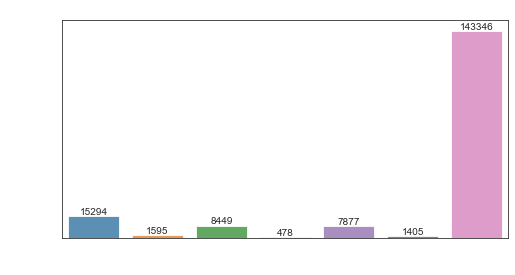

In [7]:
x = train.iloc[:, 2:].sum()
# plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('# Per Class', color='white')
plt.ylabel('# of Occurrences', fontsize=12, color='white')
plt.xlabel('Type', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')
    


In [8]:
x.values.sum()

178444

- 타입들간의 불균형 문제가 존재합니다.
- 위에서 코멘트의 수가 159571개 였는데, 그래프에 나타나는 개수는 178444개입니다.
    - 이는 하나의 코멘트가 여러 태그를 가지고 있는 (예. 한 코멘트가 독성과 음담패설을 가지고 있음) 경우를 추측해볼 수 있습니다.

### Multi-tagging
얼마나 많은 코멘트들이 다수의 태그를 가지고 있는지 확인해 보겠습니다.

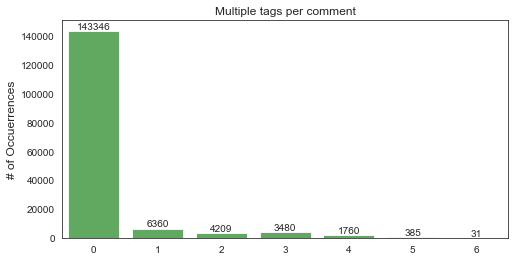

In [9]:
x = rowsums.value_counts()

# plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8, color=color[2])
plt.title('Multiple tags per comment')
plt.ylabel('# of Occuerrences', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')

In [10]:
x[2:7].sum() / x.sum()

0.06182201026502309

약 6% 정도의 코멘트가 여러 종류의 독성을 가지고 있습니다. 31개의 코멘트는 모든 종류를 다 갖고 있습니다!

### Which tags go together?
이번엔 어떤 태그들이 같이 발생하는지 알아보겠습니다. 상관관계도를 그려 확인할 수 있습니다.

<AxesSubplot:>

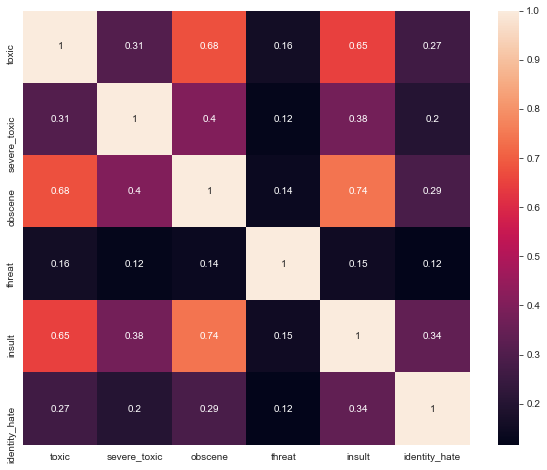

In [11]:
temp_df = train.iloc[:,2:-1]
# filter temp by removing clean comments

corr = temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)


위의 그림은 공존하는 패턴을 나타내지만 Pearson 상관 관계를 사용하는 판다스의 기분 corr 함수는 변수들이 범주형 변수이기 때문에 적용되지 않습니다.

따라서 두 범주형 변수 사이의 패턴을 찾기 위해 다음과 같은 도구를 사용할 수 있습니다.
- 혼동 매트릭스/ 크로스탭
- Cramer's V Statistics
     - Cramer's V는 카이제곱 검정의 확장입니다. 여기서 연관성의 범위/강도도 측정됩니다.

In [12]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1: # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [13]:
# Crosstab
# 모든 6개의 클래스에 대해 크로스탭을 그리는게 기술적으로 불가능하기 때문에,
# 독성과 다른 태그들에 대한 크로스탭만 살펴보겠습니다.

main_col = 'toxic'
corr_mats = []
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=temp_df.columns[1:])

# cell highlighting
out = out.style.apply(highlight_min, axis=0)
out

위 테이블은 독성 코멘트와 다른 클래스들과의 크로스탭/혼동 매트릭스를 나타냅니다.

몇 가지 흥미로운 관찰이 있습니다:
- 독성 코멘트가 아니면 심한 독성 코멘트도 아닙니다.
- 독성 코멘트의 경우 음담패설과 모욕이 절반 정도 나타납니다.
- 독성이 없을 때 보다 있을 때 다른 클래스들이 더 많이 관측됩니다. 
     - 이는 다른 클래스들이 독성 코멘트의 하위 집합이라고 봐도 될 것 같습니다.

In [14]:
def cramers_correlated_stat(confusion_matrix):
    """
    Cramer's V를 통해 범주-범주 간 연관성을 계산합니다.
    Wicher Bergsma의 상관관계를 사용합니다.
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [15]:
# Checking for Toxic and Severe toxic for now
col1 = 'toxic'
col2 = 'severe_toxic'
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print('Confusion matrix between toxic and severe toxic:')
print(confusion_matrix)
new_corr = cramers_correlated_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=", round(new_corr,4))

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.3085


### Example Comments:

In [16]:
print('toxic:')
print(train[train.toxic==1].iloc[3,1])

toxic:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [17]:
print('severe_toxic:')
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [18]:
print('Threat:')
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [19]:
print('Obscene:')
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [20]:
print('identity_hate:')
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


정말 심한 말이 많네요. 몇 가지 관측을 할 수 있습니다:
- 일부 댓글은 동일한 내용의 복사 붙여넣기에 불과합니다.
- 댓글에 IP 주소(예:62.158.73.165), 사용자 이름(예:ARKJEDI10) 및 일부 알 수 없는 번호(문서 ID로 추정)들이 포함된 경우도 있습니다.

특히 두 번째 관측은 큰 과적합을 야기할 수 있습니다.

## Wordclouds - Frequent words:
이제, 클래스들과 어떤 단어들이 연관이 있는지 살펴보겠습니다.

차트 설명: 여기서 보여지는 것은 자주 나타나는 단어를 크게 나타내는 워드 클라우드 입니다. 다음 과정을 통해 멋진 그림을 만들 수 있습니다.

```
* 기본 64 인코딩으로 된 이미지를 찾습니다.
* 셀에 인코딩을 붙여넣고 코덱 패키지를 사용하여 이미지로 변환합니다.
* 새로운 이미지를 마스크로 활용하여 워드 클라우드를 만듭니다.
```

In [21]:
stopword = set(STOPWORDS)

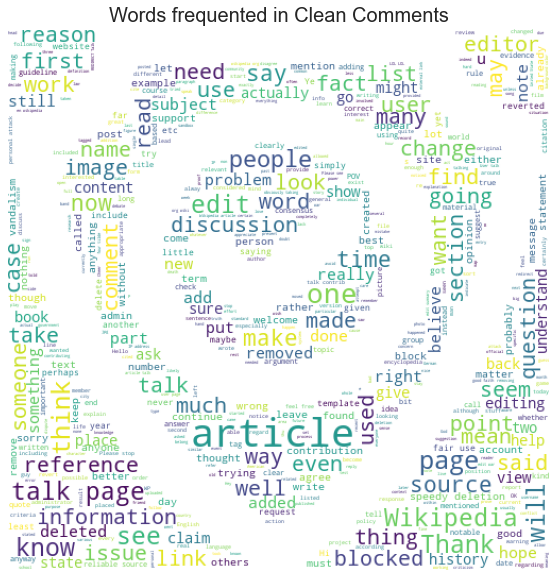

In [22]:
# clean comments
clean_mask = np.array(Image.open('./input/imagesforkernel/safe-zone.png'))
clean_mask = clean_mask[:,:,1]
# wordcloud for clean comments
subset = train[train.clean==True]
text = subset.comment_text.values
wc = WordCloud(background_color='white', max_words=2000, mask=clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.title('Words frequented in Clean Comments', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)

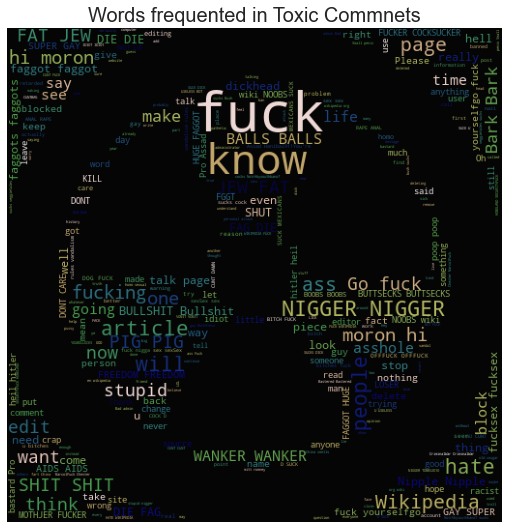

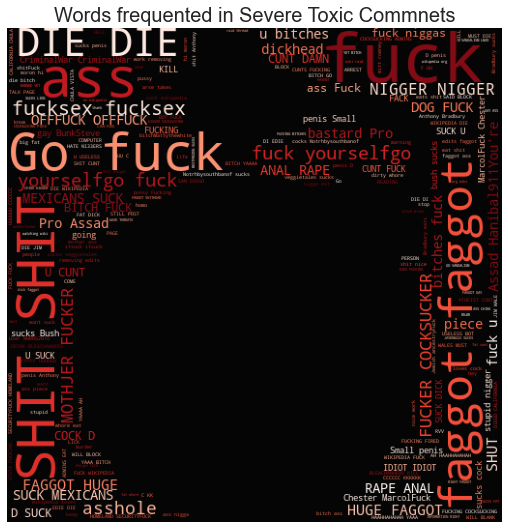

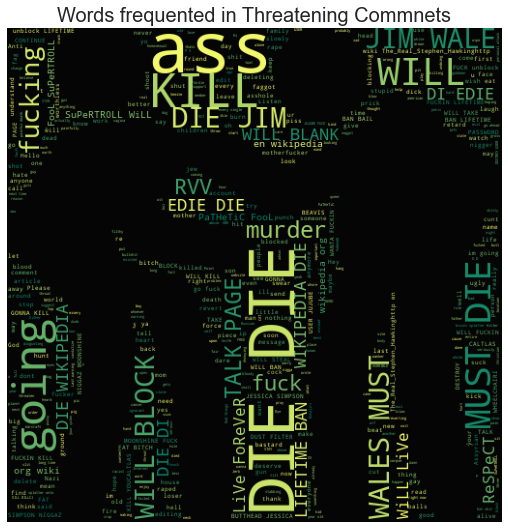

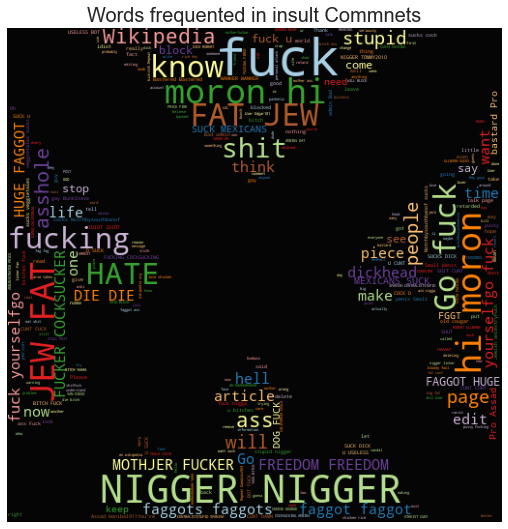

In [23]:
toxic_mask = np.array(Image.open('./input/imagesforkernel/toxic-sign.png'))
toxic_mask = toxic_mask[:, :, 1]
# wordcloud for toxic comment
subset = train[train.toxic==1]
text = subset.comment_text.values
wc = WordCloud(background_color='black', max_words=4000, mask=toxic_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis('off')
plt.title('Words frequented in Toxic Commnets', fontsize=20)
plt.imshow(wc.recolor(colormap='gist_earth', random_state=244), alpha=0.98)

# Severely toxic comments
severe_toxic_mask = np.array(Image.open('./input/imagesforkernel/bomb.png'))
severe_toxic_mask = severe_toxic_mask[:, :, 1]
subset = train[train.severe_toxic==1]
text = subset.comment_text.values
wc = WordCloud(background_color='black', max_words=4000, mask=severe_toxic_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(222)
plt.axis('off')
plt.title('Words frequented in Severe Toxic Commnets', fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)

# Threat comments
threat_mask = np.array(Image.open('./input/imagesforkernel/anger.png'))
threat_mask = threat_mask[:, :, 1]
subset = train[train.threat==1]
text = subset.comment_text.values
wc = WordCloud(background_color='black', max_words=4000, mask=threat_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(223)
plt.axis('off')
plt.title('Words frequented in Threatening Commnets', fontsize=20)
plt.imshow(wc.recolor(colormap='summer', random_state=244), alpha=0.98)

# insult
insult_mask = np.array(Image.open('./input/imagesforkernel/swords.png'))
insult_mask = insult_mask[:, :, 1]
subset = train[train.insult==1]
text = subset.comment_text.values
wc = WordCloud(background_color='black', max_words=4000, mask=insult_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(224)
plt.axis('off')
plt.title('Words frequented in insult Commnets', fontsize=20)
plt.imshow(wc.recolor(colormap='Paired_r', random_state=244), alpha=0.98)

plt.show()


## Feature engineering:
피쳐 엔지니어링 아이디어를 다음 세 그룹으로 폭 넓게 분류합니다:
### Direct features:
단어/내용에 직접적인 영향을 미치는 피쳐입니다. 다음과 같습니다.
- 단어 빈도 피쳐
- 피쳐 카운트
- Bigrams
- Trigrams
- 단어의 벡터 거리 매핑(예: Word2Vec)
- 감정 점수

### Indirect features:
좀더 실험적인 피쳐입니다.
- 문장의 수
- 단어의 수
- 고유한 단어의 수
- 글자 수
- 구두점의 수
- 대문자나 대문자로 이루어진 단어의 수
- 중지단어의 수
- 각 단어의 평균 길이

### Leaky features:
예시들로 부터 코멘트에 신원정보가 들어있음을 알고 있습니다.(IP, 유저이름 등)
그것들로 피쳐를 만들 수 있지만, 이는 해당 자료에 과적합을 만들 것입니다.
- 독성 IP 점수
- 독성 유저

__Note__: indirect와 leaky 피쳐를 먼저 생성합니다. 두 가지 이유가 있습니다:
- 카운트 피쳐(Direct features)는 정돈된 말뭉치에서 생성되야 유용합니다.
- indirect 피쳐는 데이터를 정리할 때 정보 손실을 보상하는 데 도움이 됩니다.

In [24]:
merge = pd.concat([train.iloc[:,0:2], test.iloc[:,0:2]])
df = merge.reset_index(drop=True)

In [25]:
## Indirect features

# Sentence count in each comment:
# \n의 수를 코멘트의 문장 수로 여길 수 있습니다.
df['count_sent'] = df['comment_text'].apply(lambda x: len(re.findall('\n',str(x)))+1)

# Word count in each comment:
df['count_word'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Unique word count:
df['count_unique_word'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# Letter count:
df['count_letters'] = df['comment_text'].apply(lambda x: len(str(x)))

# punctuation count:
df['count_punctuations'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# upper case words count
df['count_words_upper'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# title case words count
df['count_words_title'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
df['count_stopwords'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Average length of the words
df['mean_word_len'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [26]:
# derived features
# Word count percent in each comment:
df['word_unique_percent'] = df['count_unique_word']*100 / df['count_word']

# Punct percent in each comment:
df['punct_percent'] = df['count_punctuations']*100 / df['count_word']

In [27]:
# seperate train and test features
train_feats = df.iloc[0:len(train),]
test_feats = df.iloc[len(train):,]
# join the tags
train_tags = train.iloc[:, 2:]
train_feats = pd.concat([train_feats, train_tags], axis=1)

Text(0.5, 1.0, 'Num. of words in each comment')

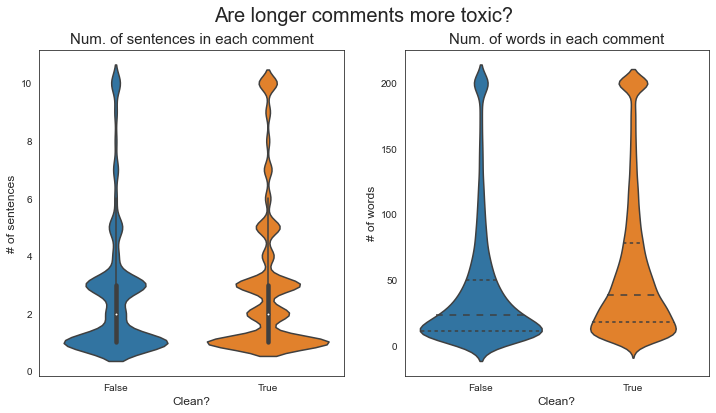

In [28]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10
plt.figure(figsize=(12, 6))

# sentences
plt.subplot(121)
plt.suptitle('Are longer comments more toxic?', fontsize=20)
sns.violinplot(y='count_sent', x='clean', data=train_feats, split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title('Num. of sentences in each comment', fontsize=15)

# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word', x='clean', data=train_feats, split=True, inner='quart')
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title('Num. of words in each comment', fontsize=15)

문장이나 단어의 길이가 독성을 나타내는 유용한 지표라고 보기 힘듭니다.

차트 설명: 바이올린그림은 전통적인 박스그림을 대체합니다. 내부의 마킹은 분위수를 나타내고 바이올린의 너비는 그 수준에 해당하는 코멘트의 수를 의미합니다.

In [29]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
# prep for split violin plots
# For the desired plots, the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
# spammers - comments with less than 30% unique words
spammers = train_feats[train_feats['word_unique_percent']<30]

Text(0, 0.5, '# of comments')

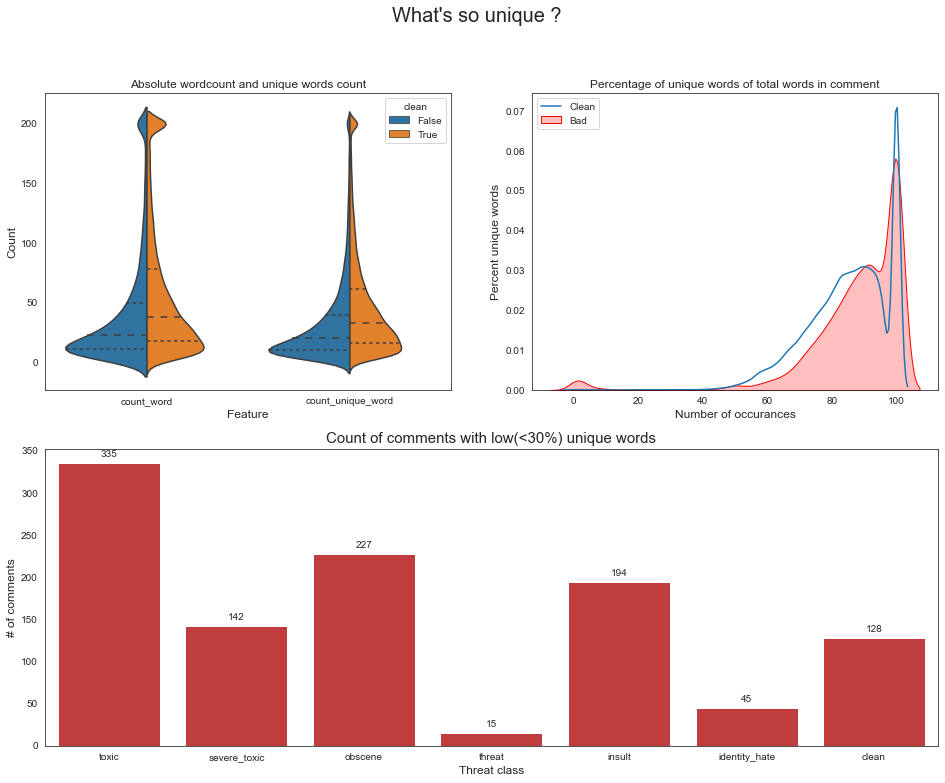

In [30]:
plt.figure(figsize=(16, 12))
plt.suptitle("What's so unique ?", fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df, split=True, inner='quartile')
plt.title('Absolute wordcount and unique words count')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title('Percentage of unique words of total words in comment')
ax = sns.kdeplot(train_feats[train_feats.clean==0].word_unique_percent, label='Bad', shade=True, color='r')
ax = sns.kdeplot(train_feats[train_feats.clean==1].word_unique_percent, label='Clean')
plt.legend()
plt.xlabel('Number of occurances', fontsize=12)
plt.ylabel('Percent unique words', fontsize=12)

x = spammers.iloc[:, -7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title('Count of comments with low(<30%) unique words', fontsize=15)
ax = sns.barplot(x=x.index, y=x.values, color=color[3])

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')
    
plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)

### Word count vs unique word count:
단어 수와 고유 단어 수 둘다 clean 과 toxic간에 평균 차이가 존재합니다.

- 차트 설명: 첫 번째 차트는 분할 바이올린 차트입니다. 범주형 변수를 기준으로 분할할 수 있습니다.

### Unique word count percent:
0-10% 부근에서 매우 적은 수의 단어가 포함된 독성 코멘트를 나타내는 돌출부가 있습니다.

- 차트 설명: 두 번째 차트는 코멘트의 모든 단어중 고유 단어 비율에 대한 커널 밀도 그림입니다. 

## Spammers are more toxic!
clean과 toxic 스팸 메세지를 살펴보겠습니다.

In [31]:
print('Clean Spam example:')
print(spammers[spammers.clean==1].comment_text.iloc[1])
print('Toxic Spam example:')
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

## Spam is toxic to the model too!
이러한 스팸 항목은 정상적인 단어 수 피쳐를 포함하도록 모델을 설계하는 경우 좋지 않습니다.

예를 들어 모델이 'mitt romney'라는 단어를 독성으로 분류하는 시나리오를 상상해 본다면 왜 좋지 않은 지 알 수 있겠죠?

## Leaky features
__주의__: 이러한 피쳐들을 포함하는 것이 이 특정한 시나리오에서 성능을 향상시킬 수 있으나, 최종 모델이나 일반적인 모델에 추가하는 것에 잘 맞지 않을 수 있습니다.

커스텀 count vectorizer을 만들고 카운트 변수를 만들어 정규표현식과 비교합니다.

In [32]:
# Leaky features
df['ip'] = df['comment_text'].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", str(x)))

# count of ip addresses
df['count_ip'] = df['ip'].apply(lambda x: len(x))

# links 
df['link'] = df['comment_text'].apply(lambda x: re.findall("http://.*com", str(x)))

# count of links
df['count_links'] = df['link'].apply(lambda x: len(x))

# article ids
df['article_id'] = df['comment_text'].apply(lambda x: re.findall("\d:\d\d\s{0,5}$", str(x)))
df['article_id_flag'] = df.article_id.apply(lambda x: len(x))

# username
# regex for match anything with [[User: ----]]
df['username'] = df['comment_text'].apply(lambda x: re.findall("\[\[User(.*)\|", str(x)))

# count of username mentions
df['count_usernames'] = df['username'].apply(lambda x: len(x))

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df['ip'].apply(lambda x: str(x)))

# Leaky usernames
cv = CountVectorizer()
count_feats_user = cv.fit_transform(df['username'].apply(lambda x: str(x)))


In [33]:
df[df.count_usernames!=0].comment_text.iloc[0]

'2010]]\n[[User talk:Wikireader41/Archive4|Archive 5-Mar 15'

In [34]:
# check few names
cv.get_feature_names()[120:130]

['destruction',
 'diablo',
 'diligent',
 'dland',
 'dlohcierekim',
 'dodo',
 'dominick',
 'douglas',
 'dpl',
 'dr']

## Leak Feature Stability:
테스트 세트 예측 시 유용성을 확인하기 위해 leaky 피쳐의 재발 여부를 확인합니다.

In [35]:
leaky_feats = df[['ip', 'link', 'article_id', 'username', 'count_ip', 'count_links', 'count_usernames', 'article_id_flag']]
leaky_feats_train = leaky_feats.iloc[:train.shape[0]]
leaky_feats_test = leaky_feats.iloc[train.shape[0]:]

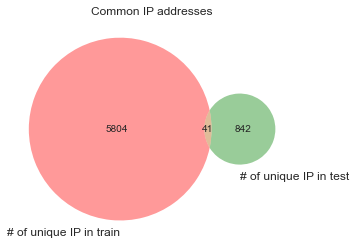

In [36]:
# filterout the entries without ips
train_ips = leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips = leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
# get the unique list of ips in test and train datasets
train_ip_list = list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list = list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list = list(set(train_ip_list).intersection(test_ip_list))
plt.title('Common IP addresses')
venn.venn2(subsets=(len(train_ip_list), len(test_ip_list), len(common_ip_list)), set_labels=('# of unique IP in train', '# of unique IP in test'))

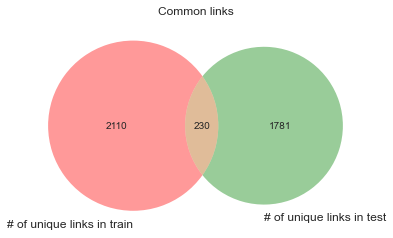

In [37]:
# filterout the entries without links
train_links = leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links = leaky_feats_test.link[leaky_feats_test.count_links!=0]
# get the unique list of links in test and train datasets
train_links_list = list(set([a for b in train_links.tolist() for a in b]))
test_links_list = list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list = list(set(train_links_list).intersection(test_links_list))
plt.title('Common links')
venn.venn2(subsets=(len(train_links_list), len(test_links_list), len(common_links_list)),
           set_labels=('# of unique links in train', '# of unique links in test'))

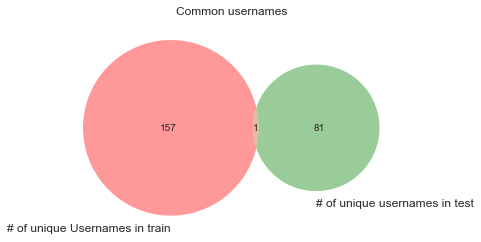

In [38]:
# filterout the entries without users
train_users = leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users = leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
# get the unique list of usernames in test and train datasets
train_users_list = list(set([a for b in train_users.tolist() for a in b]))
test_users_list = list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list = list(set(train_users_list).intersection(test_users_list))
plt.title('Common usernames')
venn.venn2(subsets=(len(train_users_list), len(test_users_list), len(common_users_list)),
           set_labels=('# of unique Usernames in train', '# of unique usernames in test'))

피쳐 안정성(재발생성)은 테스트 데이터 셋에서 훈련 데이터 셋 사용자 이름의 재발이 최소인 것처럼 보입니다. 피쳐 엔지니어링에 교집합을 사용할 수 있습니다.

[blocked IP list](https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs) 를 통해 IP 리스트의 또 다른 사용 예를 찾을 수 있습니다. 

In [39]:
#https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

blocked_ips=["216.102.6.176",
"216.120.176.2",
"203.25.150.5",
"203.217.8.30",
"66.90.101.58",
"125.178.86.75",
"210.15.217.194",
"69.36.166.207",
"213.25.24.253",
"24.60.181.235",
"71.204.14.32",
"216.91.92.18",
"212.219.2.4",
"194.74.190.162",
"64.15.152.246",
"59.100.76.166",
"146.145.221.129",
"146.145.221.130",
"74.52.44.34",
"68.5.96.201",
"65.184.176.45",
"209.244.43.209",
"82.46.9.168",
"209.200.236.32",
"209.200.229.181",
"202.181.99.22",
"220.233.226.170",
"212.138.64.178",
"220.233.227.249",
"72.14.194.31",
"72.249.45.0/24",
"72.249.44.0/24",
"80.175.39.213",
"81.109.164.45",
"64.157.15.0/24",
"208.101.10.54",
"216.157.200.254",
"72.14.192.14",
"204.122.16.13",
"217.156.39.245",
"210.11.188.16",
"210.11.188.17",
"210.11.188.18",
"210.11.188.19",
"210.11.188.20",
"64.34.27.153",
"209.68.139.150",
"152.163.100.0/24",
"65.175.48.2",
"131.137.245.197",
"131.137.245.199",
"131.137.245.200",
"64.233.172.37",
"66.99.182.25",
"67.43.21.12",
"66.249.85.85",
"65.175.134.11",
"201.218.3.198",
"193.213.85.12",
"131.137.245.198",
"83.138.189.74",
"72.14.193.163",
"66.249.84.69",
"209.204.71.2",
"80.217.153.189",
"83.138.136.92",
"83.138.136.91",
"83.138.189.75",
"83.138.189.76",
"212.100.250.226",
"212.100.250.225",
"212.159.98.189",
"87.242.116.201",
"74.53.243.18",
"213.219.59.96/27",
"212.219.82.37",
"203.38.149.226",
"66.90.104.22",
"125.16.137.130",
"66.98.128.0/17",
"217.33.236.2",
"24.24.200.113",
"152.22.0.254",
"59.145.89.17",
"71.127.224.0/20",
"65.31.98.71",
"67.53.130.69",
"204.130.130.0/24",
"72.14.193.164",
"65.197.143.214",
"202.60.95.235",
"69.39.89.95",
"88.80.215.14",
"216.218.214.2",
"81.105.175.201",
"203.108.239.12",
"74.220.207.168",
"206.253.55.206",
"206.253.55.207",
"206.253.55.208",
"206.253.55.209",
"206.253.55.210",
"66.64.56.194",
"70.91.90.226",
"209.60.205.96",
"202.173.191.210",
"169.241.10.83",
"91.121.195.205",
"216.70.136.88",
"72.228.151.208",
"66.197.167.120",
"212.219.232.81",
"208.86.225.40",
"63.232.20.2",
"206.219.189.8",
"212.219.14.0/24",
"165.228.71.6",
"99.230.151.129",
"72.91.11.99",
"173.162.177.53",
"60.242.166.182",
"212.219.177.34",
"12.104.27.5",
"85.17.92.13",
"91.198.174.192/27",
"155.246.98.61",
"71.244.123.63",
"81.144.152.130",
"198.135.70.1",
"71.255.126.146",
"74.180.82.59",
"206.158.2.80",
"64.251.53.34",
"24.29.92.238",
"76.254.235.105",
"68.96.242.239",
"203.202.234.226",
"173.72.89.88",
"87.82.229.195",
"68.153.245.37",
"216.240.128.0/19",
"72.46.129.44",
"66.91.35.165",
"82.71.49.124",
"69.132.171.231",
"75.145.183.129",
"194.80.20.237",
"98.207.253.170",
"76.16.222.162",
"66.30.100.130",
"96.22.29.23",
"76.168.140.158",
"202.131.166.252",
"89.207.212.99",
"81.169.155.246",
"216.56.8.66",
"206.15.235.10",
"115.113.95.20",
"204.209.59.11",
"27.33.141.67",
"41.4.65.162",
"99.6.65.6",
"60.234.239.169",
"2620:0:862:101:0:0:2:0/124",
"183.192.165.31",
"50.68.6.12",
"37.214.82.134",
"96.50.0.230",
"60.231.28.109",
"64.90.240.50",
"49.176.97.12",
"209.80.150.137",
"24.22.67.116",
"206.180.81.2",
"195.194.39.100",
"87.41.52.6",
"169.204.164.227",
"50.137.55.117",
"50.77.84.161",
"90.202.230.247",
"186.88.129.224",
"2A02:EC80:101:0:0:0:2:0/124",
"142.4.117.177",
"86.40.105.198",
"120.43.20.149",
"198.199.64.0/18",
"192.34.56.0/21",
"192.81.208.0/20",
"2604:A880:0:0:0:0:0:0/32",
"108.72.107.229",
"2602:306:CC2B:7000:41D3:B92D:731C:959D",
"185.15.59.201",
"180.149.1.229",
"207.191.188.66",
"210.22.63.92",
"117.253.196.217",
"119.160.119.172",
"90.217.133.223",
"194.83.8.3",
"194.83.164.22",
"217.23.228.149",
"65.18.58.1",
"168.11.15.2",
"65.182.127.31",
"207.106.153.252",
"64.193.88.2",
"152.26.71.2",
"199.185.67.179",
"117.90.240.73",
"108.176.58.170",
"195.54.40.28",
"185.35.164.109",
"192.185.0.0/16",
"2605:E000:1605:C0C0:3D3D:A148:3039:71F1",
"107.158.0.0/16",
"85.159.232.0/21",
"69.235.4.10",
"86.176.166.206",
"108.65.152.51",
"10.4.1.0/24",
"103.27.227.139",
"188.55.31.191",
"188.53.13.34",
"176.45.58.252",
"176.45.22.37",
"24.251.44.140",
"108.200.140.191",
"117.177.169.4",
"72.22.162.38",
"24.106.242.82",
"79.125.190.93",
"107.178.200.1",
"123.16.244.246",
"83.228.167.87",
"128.178.197.53",
"14.139.172.18",
"207.108.136.254",
"184.152.17.217",
"186.94.29.73",
"217.200.199.2",
"66.58.141.104",
"166.182.81.30",
"89.168.206.116",
"92.98.163.145",
"77.115.31.71",
"178.36.118.74",
"157.159.10.14",
"103.5.212.139",
"203.174.180.226",
"69.123.252.95",
"199.200.123.233",
"121.45.89.82",
"71.228.87.155",
"68.189.67.92",
"216.161.176.152",
"98.17.30.139",
"2600:1006:B124:84BD:0:0:0:103",
"117.161.0.0/16",
"12.166.68.34",
"96.243.149.64",
"74.143.90.218",
"76.10.176.221",
"104.250.128.0/19",
"185.22.183.128/25",
"89.105.194.64/26",
"202.45.119.0/24",
"73.9.140.64",
"164.127.71.72",
"50.160.129.2",
"49.15.213.207",
"83.7.192.0/18",
"201.174.63.79",
"2A02:C7D:4643:8F00:D09D:BE1:D2DE:BB1F",
"125.60.195.230",
"49.145.113.145",
"168.18.160.134",
"72.193.218.222",
"199.216.164.10",
"120.144.130.89",
"104.130.67.208",
"50.160.221.147",
"163.47.141.50",
"91.200.12.136",
"83.222.0.0/19",
"67.231.16.0/20",
"72.231.0.196",
"180.216.68.197",
"183.160.178.135",
"183.160.176.16",
"24.25.221.150",
"92.222.109.43",
"142.134.243.215",
"216.181.221.72",
"113.205.170.110",
"74.142.2.98",
"192.235.8.3",
"2402:4000:BBFC:36FC:E469:F2F0:9351:71A0",
"80.244.81.191",
"2607:FB90:1377:F765:D45D:46BF:81EA:9773",
"2600:1009:B012:7D88:418B:54BA:FCBC:4584",
"104.237.224.0/19",
"2600:1008:B01B:E495:C05A:7DD3:926:E83C",
"168.8.249.234",
"162.211.179.36",
"138.68.0.0/16",
"145.236.37.195",
"67.205.128.0/18",
"2A02:C7D:2832:CE00:B914:19D6:948D:B37D",
"107.77.203.212",
"2607:FB90:65C:A136:D46F:23BA:87C2:3D10",
"2A02:C7F:DE2F:7900:5D64:E991:FFF0:FA93",
"82.23.32.186",
"106.76.243.74",
"82.33.48.223",
"180.216.160.0/19",
"94.102.184.35",
"94.102.184.26",
"109.92.162.54",
"2600:8800:7180:BF00:4C27:4591:347C:736C",
"178.41.186.50",
"184.97.134.128",
"176.221.32.0/22",
"207.99.40.142",
"109.97.241.134",
"82.136.64.19",
"91.236.74.119",
"197.210.0.0/16",
"173.230.128.0/19",
"162.216.16.0/22",
"80.111.222.211",
"191.37.28.21",
"124.124.103.194",
"50.207.7.198",
"220.233.131.98",
"107.77.241.11",
"68.112.39.0/27",
"173.236.128.0/17",
"49.49.240.24",
"96.31.10.178",
"50.251.229.75"]

In [40]:
train_ip_list = list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list = list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
blocked_ip_list_train = list(set(train_ip_list).intersection(blocked_ips))
blocked_ip_list_test = list(set(test_ip_list).intersection(blocked_ips))

print('There are', len(blocked_ip_list_train), 'blocked IPs in train dataset')
print('There are', len(blocked_ip_list_test), 'blocked IPs in test dataset')

There are 6 blocked IPs in train dataset
There are 0 blocked IPs in test dataset


흥미롭지만 유용하지는 않은 결과입니다. 전체 코멘트에서 언급된 IP 중 단지 6개의 블락된 IP만 존재합니다.

In [41]:
end_time = time.time()
print('total time till Leaky feats', end_time-start_time)

total time till Leaky feats 190.91949558258057


## Corpus cleaning
카운트 피쳐를 만들기 전에 데이터셋을 정리하는 것은 중요합니다.

In [42]:
corpus = merge.comment_text

In [43]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [44]:
def clean(comment):
    """
    코멘트를 받아서 정제된 단어 리스트 반환
    """
    # Convert to lower case, so that Hi and hi are the same
    comment = comment.lower()
    # remove \n
    comment = re.sub("\\n", "", comment)
    # remove leaky elements like ip, user
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    # removing usernames
    comment = re.sub("\[\[.*\]", "", comment)
    
    # Split the sentences into words
    words = tokenizer.tokenize(comment)
    
    # (') aphostrophe replacement (ie) you're -> you are
    words = [APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, 'v') for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent = " ".join(words)
    return(clean_sent)

In [45]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [46]:
clean(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [47]:
clean_corpus = corpus.apply(lambda x: clean(x))

end_time = time.time()
print('total time till Cleaning', end_time-start_time)

total time till Cleaning 664.3689270019531


## Direct features:

### 1) Count based features(for unigrams)
단어의 빈도 분포에 기반한 몇 가지 피쳐를 만듭니다. 처음에는 단어들을 한 번에 하나씩 처리하는 것부터 시작합니다. 예)유니그램

파이썬의 Sklearn은 카운트 기능을 생성하는 3가지 방법을 제공합니다. 세 기능 모두 처음으로는 단어의 사전을 만들고 현재 사전에 있는 문장의 단어 카운트에 대한 희소 행렬을 생성합니다. 세 기능에 대한 간단한 설명은 다음과 같습니다.

- CountVectorizer
    - 말뭉치 속 단어 카운트 빈도에 대한 행렬 생성
 
- TF-IDF Vectorizer
    - TF - Term Frequency -- 말뭉치속 단어의 수(CountVectorizer와 동일)
    - IDF - Inverse Document Frequency -- 너무 자주 나오는 단어에 패널티. 정규화 처럼 생각할 수 있음
    
- HashingVectorizer
    - 단어의 사전을 만드는 대신 해시맵(해싱 기술에 기반한 단어를 숫자로 매핑)을 생성
    - 더 큰 말뭉치에 대해 확장성과 속도를 높일 수 있음
    - 여러 스레드에 걸쳐 병렬화 가능
    
이 노트북에서는 TF-IDF를 사용합니다.

훈련 및 테스트 데이터 세트의 텍스트를 모두 포함하는 연결된 데이터 프레임 `merge`를 사용하여 생성하는 어휘가 테스트 세트에만 있는 단어를 놓치지 않도록 합니다.

In [48]:
# strip_accents='unicode': remove accents, 'unicode' works any characters
# analyzer='word': create features from words
# ngram_range=(1,1): unigram
# use_idf=1, smooth_idf=1: enable IDF
# sublinear_tf=1: apply sublinear tf scaling. replace tf with 1+log(tf)
start_unigrams = time.time()
tfv = TfidfVectorizer(min_df=200, max_features=10000,
                      strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                      use_idf=1, smooth_idf=1, sublinear_tf=1,
                      stop_words='english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [49]:
def top_tfidf_feats(row, features, top_n=25):
    """상위 n개의 tfidf 값을 받고 상승하는 피쳐 이름 반환"""
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    """특정 문서의 상위 tfidf 피쳐"""
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    """grp_ids에 의해 인덱싱된 행에 있는 문서중에서 평균적으로 가장 중요한 
     상위 n개 피쳐 반환 """
    D = Xtr[grp_ids].toarray()
    
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    """각 df가 같은 클래스 레이블에 있는 문서에서 계산된 평균 tfidf 값과 top_n 피쳐를 담고있는 dfs의 리스트로 반환"""
    dfs = []
    cols = train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, 
                                  min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [50]:
# get top n for unigrams
tfidf_top_n_per_class = top_feats_by_class(train_unigrams, features)

end_unigrams = time.time()

print('total time in unigrams', end_unigrams-start_unigrams)
print('total time till unigrams', end_unigrams-start_time)

total time in unigrams 79.60462880134583
total time till unigrams 743.9874758720398


Text(0, 0.5, 'TF-IDF score')

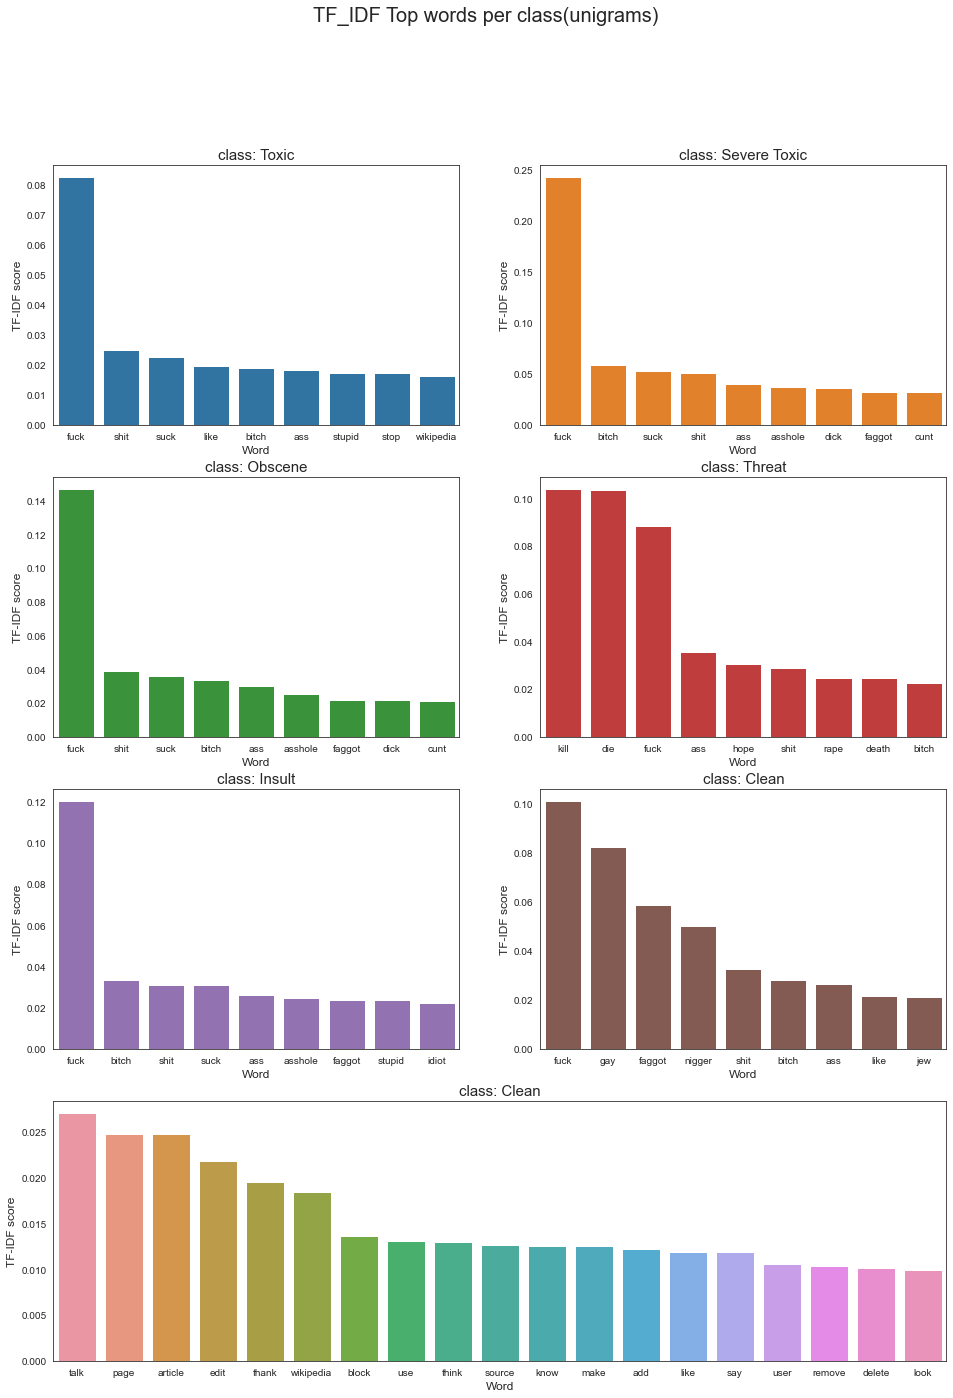

In [51]:
plt.figure(figsize=(16,22))
plt.suptitle('TF_IDF Top words per class(unigrams)', fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_class[0].feature.iloc[0:9],tfidf_top_n_per_class[0].tfidf.iloc[0:9], color=color[0])
plt.title('class: Toxic', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_class[1].feature.iloc[0:9],tfidf_top_n_per_class[1].tfidf.iloc[0:9], color=color[1])
plt.title('class: Severe Toxic', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_class[2].feature.iloc[0:9],tfidf_top_n_per_class[2].tfidf.iloc[0:9], color=color[2])
plt.title('class: Obscene', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_class[3].feature.iloc[0:9],tfidf_top_n_per_class[3].tfidf.iloc[0:9], color=color[3])
plt.title('class: Threat', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_class[4].feature.iloc[0:9],tfidf_top_n_per_class[4].tfidf.iloc[0:9], color=color[4])
plt.title('class: Insult', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_class[5].feature.iloc[0:9],tfidf_top_n_per_class[5].tfidf.iloc[0:9], color=color[5])
plt.title('class: Clean', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(3,0), colspan=2)
sns.barplot(tfidf_top_n_per_class[6].feature.iloc[0:19],tfidf_top_n_per_class[6].tfidf.iloc[0:19])
plt.title('class: Clean', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

In [52]:
# temp settings to min=150 to faciliate top features section to run kernals
# change back to min=10 to get better results
tfv = TfidfVectorizer(min_df=150, max_features=30000,
                      strip_accents='unicode', analyzer='word', ngram_range=(2,2)
                     ,use_idf=1, smooth_idf=1, sublinear_tf=1,
                      stop_words='english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
# get top n for bigrams
tfidf_top_n_per_class = top_feats_by_class(train_bigrams, features)

Text(0, 0.5, 'TF-IDF score')

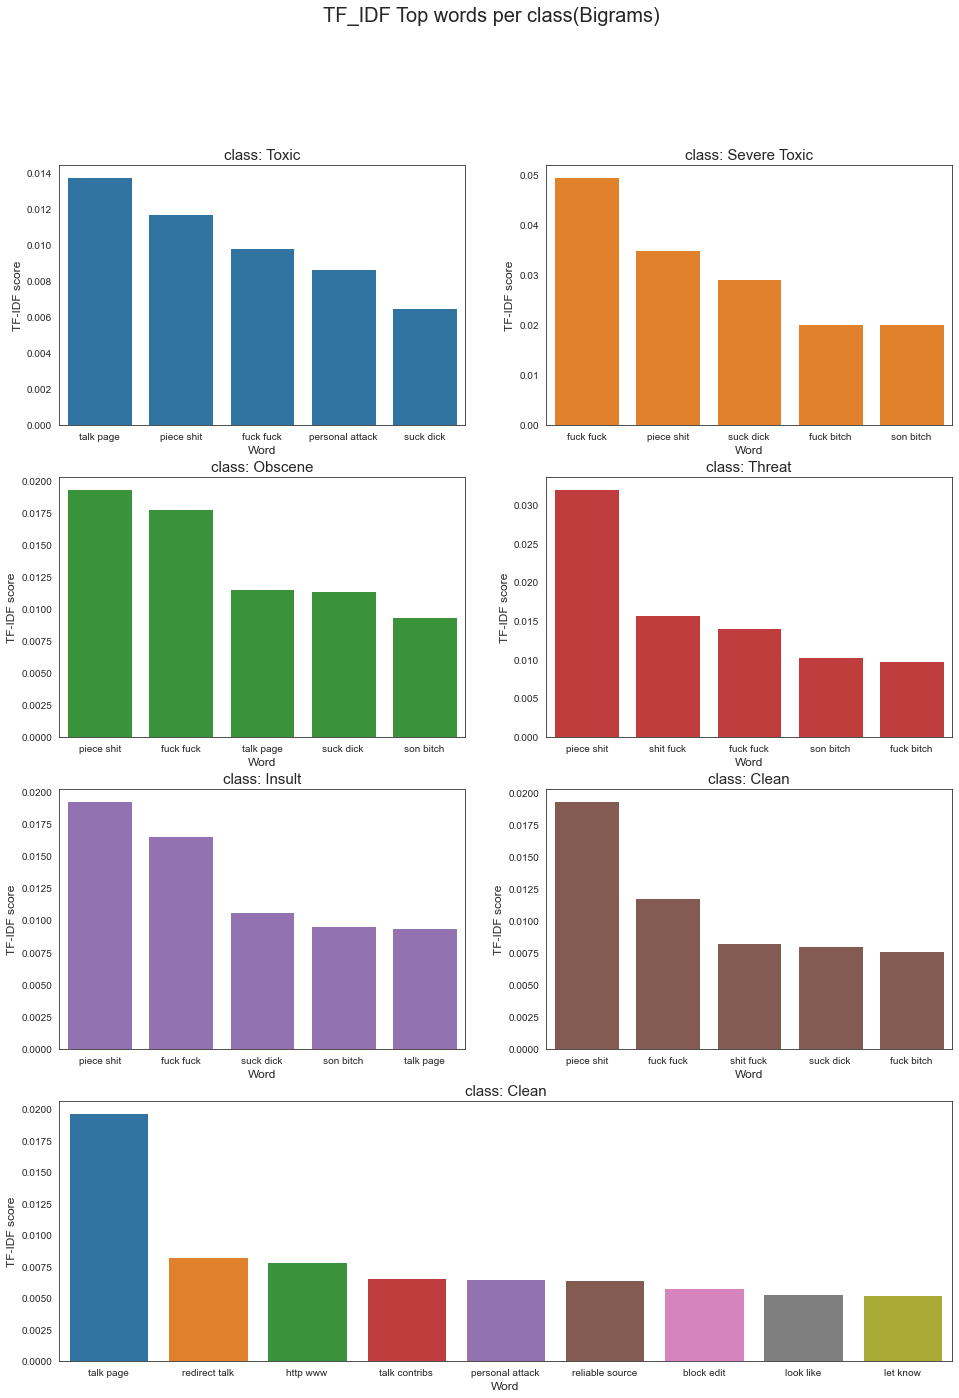

In [53]:
plt.figure(figsize=(16,22))
plt.suptitle('TF_IDF Top words per class(Bigrams)', fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_class[0].feature.iloc[0:5],tfidf_top_n_per_class[0].tfidf.iloc[0:5], color=color[0])
plt.title('class: Toxic', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_class[1].feature.iloc[0:5],tfidf_top_n_per_class[1].tfidf.iloc[0:5], color=color[1])
plt.title('class: Severe Toxic', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_class[2].feature.iloc[0:5],tfidf_top_n_per_class[2].tfidf.iloc[0:5], color=color[2])
plt.title('class: Obscene', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_class[3].feature.iloc[0:5],tfidf_top_n_per_class[3].tfidf.iloc[0:5], color=color[3])
plt.title('class: Threat', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_class[4].feature.iloc[0:5],tfidf_top_n_per_class[4].tfidf.iloc[0:5], color=color[4])
plt.title('class: Insult', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_class[5].feature.iloc[0:5],tfidf_top_n_per_class[5].tfidf.iloc[0:5], color=color[5])
plt.title('class: Clean', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(3,0), colspan=2)
sns.barplot(tfidf_top_n_per_class[6].feature.iloc[0:9],tfidf_top_n_per_class[6].tfidf.iloc[0:9])
plt.title('class: Clean', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

In [54]:
end_time = time.time()
print('total time till bigrams', end_time-start_time)

total time till bigrams 858.6475739479065


In [55]:
tfv = TfidfVectorizer(min_df=100, max_features=30000,
                      strip_accents='unicode', analyzer='char', ngram_range=(1,4),
                      use_idf=1, smooth_idf=1, sublinear_tf=1,
                      stop_words='english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_charngrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
end_time = time.time()
print('total time till charngrams', end_time-start_time)

total time till charngrams 1588.6019656658173


## Baseline Model:

In [56]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
        
    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))
    
    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))
    
    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)
        
        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)
        
        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [57]:
SELECTED_COLS = ['count_sent', 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations', 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'word_unique_percent', 'punct_percent']
target_x = train_feats[SELECTED_COLS]

TARGET_COLS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y = train_tags[TARGET_COLS]

In [58]:
print('Using only Indirect features')
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class: '+j)
    model.fit(X_train, y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class = log_loss(y_train[j], preds_train[:,i])
    valid_loss_class = log_loss(y_valid[j], preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss: Train dataset', np.mean(train_loss))
print('mean column-wise log loss: Validation dataset', np.mean(valid_loss))

end_time = time.time()
print('total time till Indirect feat model', end_time-start_time)

Using only Indirect features


MemoryError: Unable to allocate array with shape (106912, 106912) and data type float64

In [ ]:
importance[0][0]

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle('Feature importance for indirect features', fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title('class: Toxic', fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
pltlt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title('class: Severe Toxic', fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
pltlt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title('class: Obscene', fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
pltlt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title('class: Threat', fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
pltlt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[45])
plt.title('class: Insult', fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
pltlt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title('class: Identity hate', fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
pltlt.ylabel('Importance', fontsize=12)

In [ ]:
from scipy.sparse import csr_matrix, hstack

# Using all direct features
print('Using all features except leaky ones')
target_x = hstack((train_bigrams, train_charngrams, train_unigrams, train_feats[SELECTED_COLS])).tocsr()

end_time = time.time()
print('total time till Sparse mat creation', end_time-start_time)

In [59]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train, y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class = log_loss(y_train[j], preds_train[:,i])
    valid_loss_class = log_loss(y_valid[j], preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
    
print('mean column-wise log loss: Train dataset', np.mean(train_loss))
print('mean column-wise log loss: Validation dataset', np.mean(valid_loss))

end_time = time.time()
print('total time till NB base model creation', end_time-start_time)

MemoryError: Unable to allocate array with shape (106912, 106912) and data type float64